In [2]:
%env CLEARML_WEB_HOST=https://app.clear.ml
%env CLEARML_API_HOST=https://api.clear.ml
%env CLEARML_FILES_HOST=https://files.clear.ml
%env CLEARML_API_ACCESS_KEY=AX7NHJP0TVP297QBNOE2
%env CLEARML_API_SECRET_KEY=eZNendAKeSjc3hNYqOjEIYgoYKSqaa4ZhAYSKJJYGMvOFnKYbh

env: CLEARML_WEB_HOST=https://app.clear.ml
env: CLEARML_API_HOST=https://api.clear.ml
env: CLEARML_FILES_HOST=https://files.clear.ml
env: CLEARML_API_ACCESS_KEY=AX7NHJP0TVP297QBNOE2
env: CLEARML_API_SECRET_KEY=eZNendAKeSjc3hNYqOjEIYgoYKSqaa4ZhAYSKJJYGMvOFnKYbh


In [3]:
from clearml import Task
task = Task.init(
    project_name='cars_damaged_detecting',
    task_name='model_train_M',
    #tags=['CatBoost','RandomSearch']
    )

ClearML Task: created new task id=de4befd477a941639d608758e50bc1c4
2023-12-20 17:17:58,585 - clearml.Task - INFO - No repository found, storing script code instead
ClearML results page: https://app.clear.ml/projects/1f40c1e50dfc45dea900678692664de9/experiments/de4befd477a941639d608758e50bc1c4/output/log


In [4]:
from google.colab import drive
drive.mount('/content/drive')

# Загрузка базы
import gdown
from PIL import Image, ImageDraw, ImageFont
import cv2

# Отрисовка графиков
import matplotlib.pyplot as plt
%matplotlib inline

Mounted at /content/drive


In [5]:
def get_addr(google_add:str):  # переделывает ссылки из google
    temp_str = google_add.split('/')[-2]
    return f'https://drive.google.com/uc?id={temp_str}'

In [17]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="AujVadRIqTT8kja5pvId")
project = rf.workspace("carsdamagesdetecting").project("car_damage_segm_dataset_5")
dataset = project.version(14).download("yolov8")




loading Roboflow workspace...
loading Roboflow project...
Dependency ultralytics==8.0.196 is required but found version=8.0.228, to fix: `pip install ultralytics==8.0.196`



Extracting Dataset Version Zip to car_damage_segm_dataset_5-14 in yolov8:: 100%|██████████| 11980/11980 [00:08<00:00, 1484.19it/s]


In [ ]:
# запускать, если датасет на гугл диске

new_addr = get_addr('https://drive.google.com/file/d/1OU0vYy9pxfCh7il1p-RhEaOZGGWPiu_X/view?usp=sharing') # загрузка датасета

gdown.download(new_addr, output=None, quiet=True)

!unzip -q "cars_damages_segm_dataset_all.zip"

#https://drive.google.com/file/d/1Ehma83RM_hi5UwmwBefQZBRNaZGPyghJ/view?usp=sharing

In [11]:
!pip install ultralytics

In [18]:
# подправляем ошибку в YAML

import os
dataset_path = f'/content/{dataset.name}-{dataset.version}/'
yaml_path = dataset_path + 'data.yaml'
with open(yaml_path, 'r', encoding = 'utf-8') as yf:
    yf_lines = yf.readlines()

with open('temp.txt', 'w', encoding = 'utf-8') as tf:
  for line in yf_lines:
    if line.startswith('test:'):
        tf.write('test: test/images\n')
    elif line.startswith('train:'):
        tf.write('train: train/images\n')
    elif line.startswith('val:'):
        tf.write('val: valid/images\n')
    else:
        tf.write(line)
os.rename('temp.txt', yaml_path)



In [13]:
yaml_path

'/content/car_damage_segm_dataset_5-13/data.yaml'

In [19]:
# создаем название папки
#import os
from datetime import datetime

current_datetime = datetime.now()
str_time = f'{current_datetime.month}.{current_datetime.day}-{current_datetime.hour}.{current_datetime.minute}.{current_datetime.second}/'

PROJECT_NAME = "car_test/M_new5/"
runs_dir = '/content/drive/MyDrive/YOLOv8/' + PROJECT_NAME + str_time
#os.makedirs(runs_dir, exist_ok=True)

In [20]:

from ultralytics import YOLO
#from ultralytics import settings


#settings.update({'runs_dir': runs_dir})
#settings.update({'weights_dir':runs_dir})

new_addr = get_addr('https://drive.google.com/file/d/10NzuX0JRNG-y53PDreTVNh99A5yQS_wQ/view?usp=sharing') # адрес last.pt

gdown.download(new_addr, output=None, quiet=True) #скачать last.pt

#https://drive.google.com/file/d/1Tci2Ck0ccgyYmSNVkwxOEk0wHsnMFCEv/view?usp=sharing


#model = YOLO("yolov8m-seg.pt")  # загрузите предварительно обученную модель YOLOv8n
model = YOLO("/content/best.pt")




2023-12-20 17:35:42,969 - clearml.model - WARNING - Connecting multiple input models with the same name: `best`. This might result in the wrong model being used when executing remotely


In [ ]:
#task.upload_artifact(name='mylast', artifact_object=os.path.join('/content/runs/segment/train/weights/'))

True

In [ ]:
train_result = model.train(data=yaml_path,
                           epochs=300,
                           verbose=True,
                           optimizer = "Adam",
                           resume = True,
                           save = True,
                           #save_period = 5,
                           patience = 0,
                           pretrained = True,
                           warmup_epochs = 0,
                           project = runs_dir,
                           #name = '',
                           # save_dir = runs_dir, #уже не работает
                           momentum = 0.95, # SGD momentum/Adam beta1. / это метод оптимизации, который помогает ускорить и стабилизировать обучение нейронных сетей. Он работает путем добавления фракции градиента предыдущего шага к текущему градиенту при обновлении весов.
                           lr0 = 0.0001,
                           lrf = 0.0001,
                           )

task.close()


Ultralytics YOLOv8.0.228 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=segment, mode=train, model=/content/drive/MyDrive/YOLOv8/car_test/M_new4/12.20-7.26.49/train/weights/last.pt, data=/content/car_damage_segm_dataset_5-10/data.yaml, epochs=300, time=None, patience=0, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=/content/drive/MyDrive/YOLOv8/car_test/M_new4/12.20-7.26.49/, name=train, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, sh

train: Scanning /content/car_damage_segm_dataset_5-10/train/labels... 5092 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5092/5092 [00:03<00:00, 1513.05it/s]


train: New cache created: /content/car_damage_segm_dataset_5-10/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/car_damage_segm_dataset_5-10/valid/labels... 851 images, 0 backgrounds, 0 corrupt: 100%|██████████| 851/851 [00:01<00:00, 742.55it/s]


val: New cache created: /content/car_damage_segm_dataset_5-10/valid/labels.cache
Plotting labels to /content/drive/MyDrive/YOLOv8/car_test/M_new4/12.20-7.26.49/train/labels.jpg... 
optimizer: Adam(lr=0.0001, momentum=0.95) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
300 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     51/300      9.37G     0.9746      1.904     0.8522      1.127         31        640: 100%|██████████| 319/319 [05:37<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:19<00:00,  1.39it/s]

                   all        851       1878      0.746      0.647      0.666      0.471      0.741      0.642      0.655       0.37



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     52/300       9.9G     0.9665      1.855     0.8434      1.113         15        640: 100%|██████████| 319/319 [05:37<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:20<00:00,  1.31it/s]

                   all        851       1878       0.74      0.614      0.669      0.471      0.739      0.605      0.647      0.377



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     53/300      9.92G     0.9694      1.866     0.8442      1.113         37        640: 100%|██████████| 319/319 [05:45<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:20<00:00,  1.32it/s]

                   all        851       1878      0.696      0.626      0.646      0.457      0.692      0.619       0.63      0.363



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     54/300      9.54G      0.953      1.823     0.8225      1.111         29        640: 100%|██████████| 319/319 [06:00<00:00,  1.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:20<00:00,  1.31it/s]

                   all        851       1878      0.698      0.613      0.642      0.452      0.688      0.607      0.624       0.36



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     55/300      9.92G     0.9516      1.802     0.8069        1.1         53        640: 100%|██████████| 319/319 [06:00<00:00,  1.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:21<00:00,  1.26it/s]

                   all        851       1878      0.672      0.643      0.635       0.44      0.657       0.63      0.612      0.351



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     56/300        10G      0.946      1.806     0.8026        1.1         42        640: 100%|██████████| 319/319 [05:49<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:22<00:00,  1.22it/s]

                   all        851       1878      0.719      0.552      0.619      0.428      0.717      0.538      0.597       0.34



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     57/300        10G     0.9405       1.78     0.7926      1.093         21        640: 100%|██████████| 319/319 [05:55<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:20<00:00,  1.29it/s]

                   all        851       1878      0.698      0.582      0.598      0.411      0.679      0.564      0.569      0.325



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     58/300      9.66G     0.9295      1.766      0.776      1.089         36        640: 100%|██████████| 319/319 [06:25<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:20<00:00,  1.31it/s]

                   all        851       1878      0.656        0.6      0.589      0.405      0.641      0.588      0.571      0.321



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     59/300      10.1G     0.9452      1.774     0.7815      1.097         27        640: 100%|██████████| 319/319 [06:11<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:21<00:00,  1.25it/s]

                   all        851       1878      0.636      0.623      0.584      0.395       0.63      0.603      0.565      0.321



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     60/300      9.84G     0.9405      1.765     0.7771       1.09         40        640: 100%|██████████| 319/319 [06:07<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:21<00:00,  1.25it/s]

                   all        851       1878      0.683      0.606      0.609      0.414      0.685      0.584      0.587      0.338



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     61/300      10.1G      0.926      1.744     0.7637       1.08         30        640: 100%|██████████| 319/319 [05:58<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:19<00:00,  1.42it/s]

                   all        851       1878      0.657      0.613      0.611       0.41      0.641      0.579       0.58      0.327



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     62/300       9.9G     0.9229       1.74     0.7654      1.083         19        640: 100%|██████████| 319/319 [05:37<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:24<00:00,  1.11it/s]

                   all        851       1878      0.658       0.59      0.593      0.404       0.65      0.582      0.573      0.326



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     63/300        10G     0.9181      1.727     0.7534      1.079         15        640: 100%|██████████| 319/319 [06:06<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:23<00:00,  1.17it/s]

                   all        851       1878      0.699      0.593      0.612      0.414      0.673       0.58      0.577      0.329



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     64/300      9.92G     0.9206       1.72     0.7462      1.078         14        640: 100%|██████████| 319/319 [05:44<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:20<00:00,  1.31it/s]

                   all        851       1878      0.628      0.628      0.599      0.396      0.591      0.622      0.562      0.312



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     65/300       9.9G     0.9113      1.704     0.7397      1.075         20        640: 100%|██████████| 319/319 [06:30<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:21<00:00,  1.26it/s]

                   all        851       1878      0.718       0.58      0.601      0.406      0.702      0.563      0.577       0.32



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     66/300      9.65G     0.9041      1.705     0.7367       1.07         50        640: 100%|██████████| 319/319 [06:08<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:19<00:00,  1.36it/s]

                   all        851       1878      0.645      0.599      0.578      0.395      0.618       0.58      0.544      0.311



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     67/300      9.98G     0.9035      1.688     0.7249      1.069         21        640: 100%|██████████| 319/319 [05:44<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:19<00:00,  1.39it/s]

                   all        851       1878      0.641      0.611       0.59      0.398       0.62       0.59      0.555      0.319



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     68/300      10.1G      0.901      1.685     0.7206       1.07         33        640: 100%|██████████| 319/319 [05:42<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:19<00:00,  1.38it/s]

                   all        851       1878      0.617       0.63      0.585      0.393      0.598      0.608      0.559      0.318



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     69/300      9.93G     0.8934      1.674     0.7131      1.065         44        640: 100%|██████████| 319/319 [06:04<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:21<00:00,  1.28it/s]

                   all        851       1878      0.665      0.582      0.581      0.386      0.645      0.562      0.547      0.308



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     70/300      9.74G     0.8945      1.681     0.7213      1.063         17        640: 100%|██████████| 319/319 [06:04<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:20<00:00,  1.32it/s]

                   all        851       1878      0.646      0.579      0.578      0.377       0.64      0.561      0.553      0.299



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     71/300      9.95G     0.8913      1.675     0.7145      1.066        119        640:  32%|███▏      | 102/319 [01:54<03:04,  1.18it/s]Exception in thread Thread-43:
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/usr/local/lib/python3.10/dist-packages/tensorboard/summary/writer/event_file_writer.py", line 244, in run
    self._run()
  File "/usr/local/lib/python3.10/dist-packages/tensorboard/summary/writer/event_file_writer.py", line 289, in _run
    self._record_writer.flush()
  File "/usr/local/lib/python3.10/dist-packages/tensorboard/summary/writer/record_writer.py", line 43, in flush
    self._writer.flush()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/lib/io/file_io.py", line 221, in flush
    self._writable_file.flush()
tensorflow.python.framework.errors_impl.FailedPreconditionError: /content/drive/MyDrive/YOLOv8/car_test/M_new4/12.20-7.26.49/train/events.out.tfevents.17

FailedPreconditionError: ignored

In [21]:
result = model.val(show = True, data=yaml_path)

Ultralytics YOLOv8.0.228 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8m-seg summary (fused): 245 layers, 27226437 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /content/car_damage_segm_dataset_5-14/valid/labels... 900 images, 0 backgrounds, 0 corrupt: 100%|██████████| 900/900 [00:00<00:00, 1698.24it/s]


val: New cache created: /content/car_damage_segm_dataset_5-14/valid/labels.cache


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:32<00:00,  1.76it/s]


                   all        900       2016      0.782      0.653      0.714      0.538      0.781      0.644       0.69      0.446
          broken_glass        900        228      0.829       0.75      0.787      0.595      0.805      0.726      0.748      0.527
           broken_lamp        900         71      0.564      0.549      0.565      0.446      0.574      0.549       0.53      0.382
             corrosion        900         29       0.68      0.621      0.601      0.433      0.688      0.621      0.564      0.308
                  dent        900        503      0.871      0.686      0.801      0.525      0.871      0.672      0.786      0.455
             flat_tyre        900         14      0.975      0.857       0.91      0.852      0.978      0.857       0.91      0.829
                   gap        900        175      0.696      0.583      0.632      0.446      0.699      0.571      0.615      0.281
               scratch        900        996      0.858      0.526   

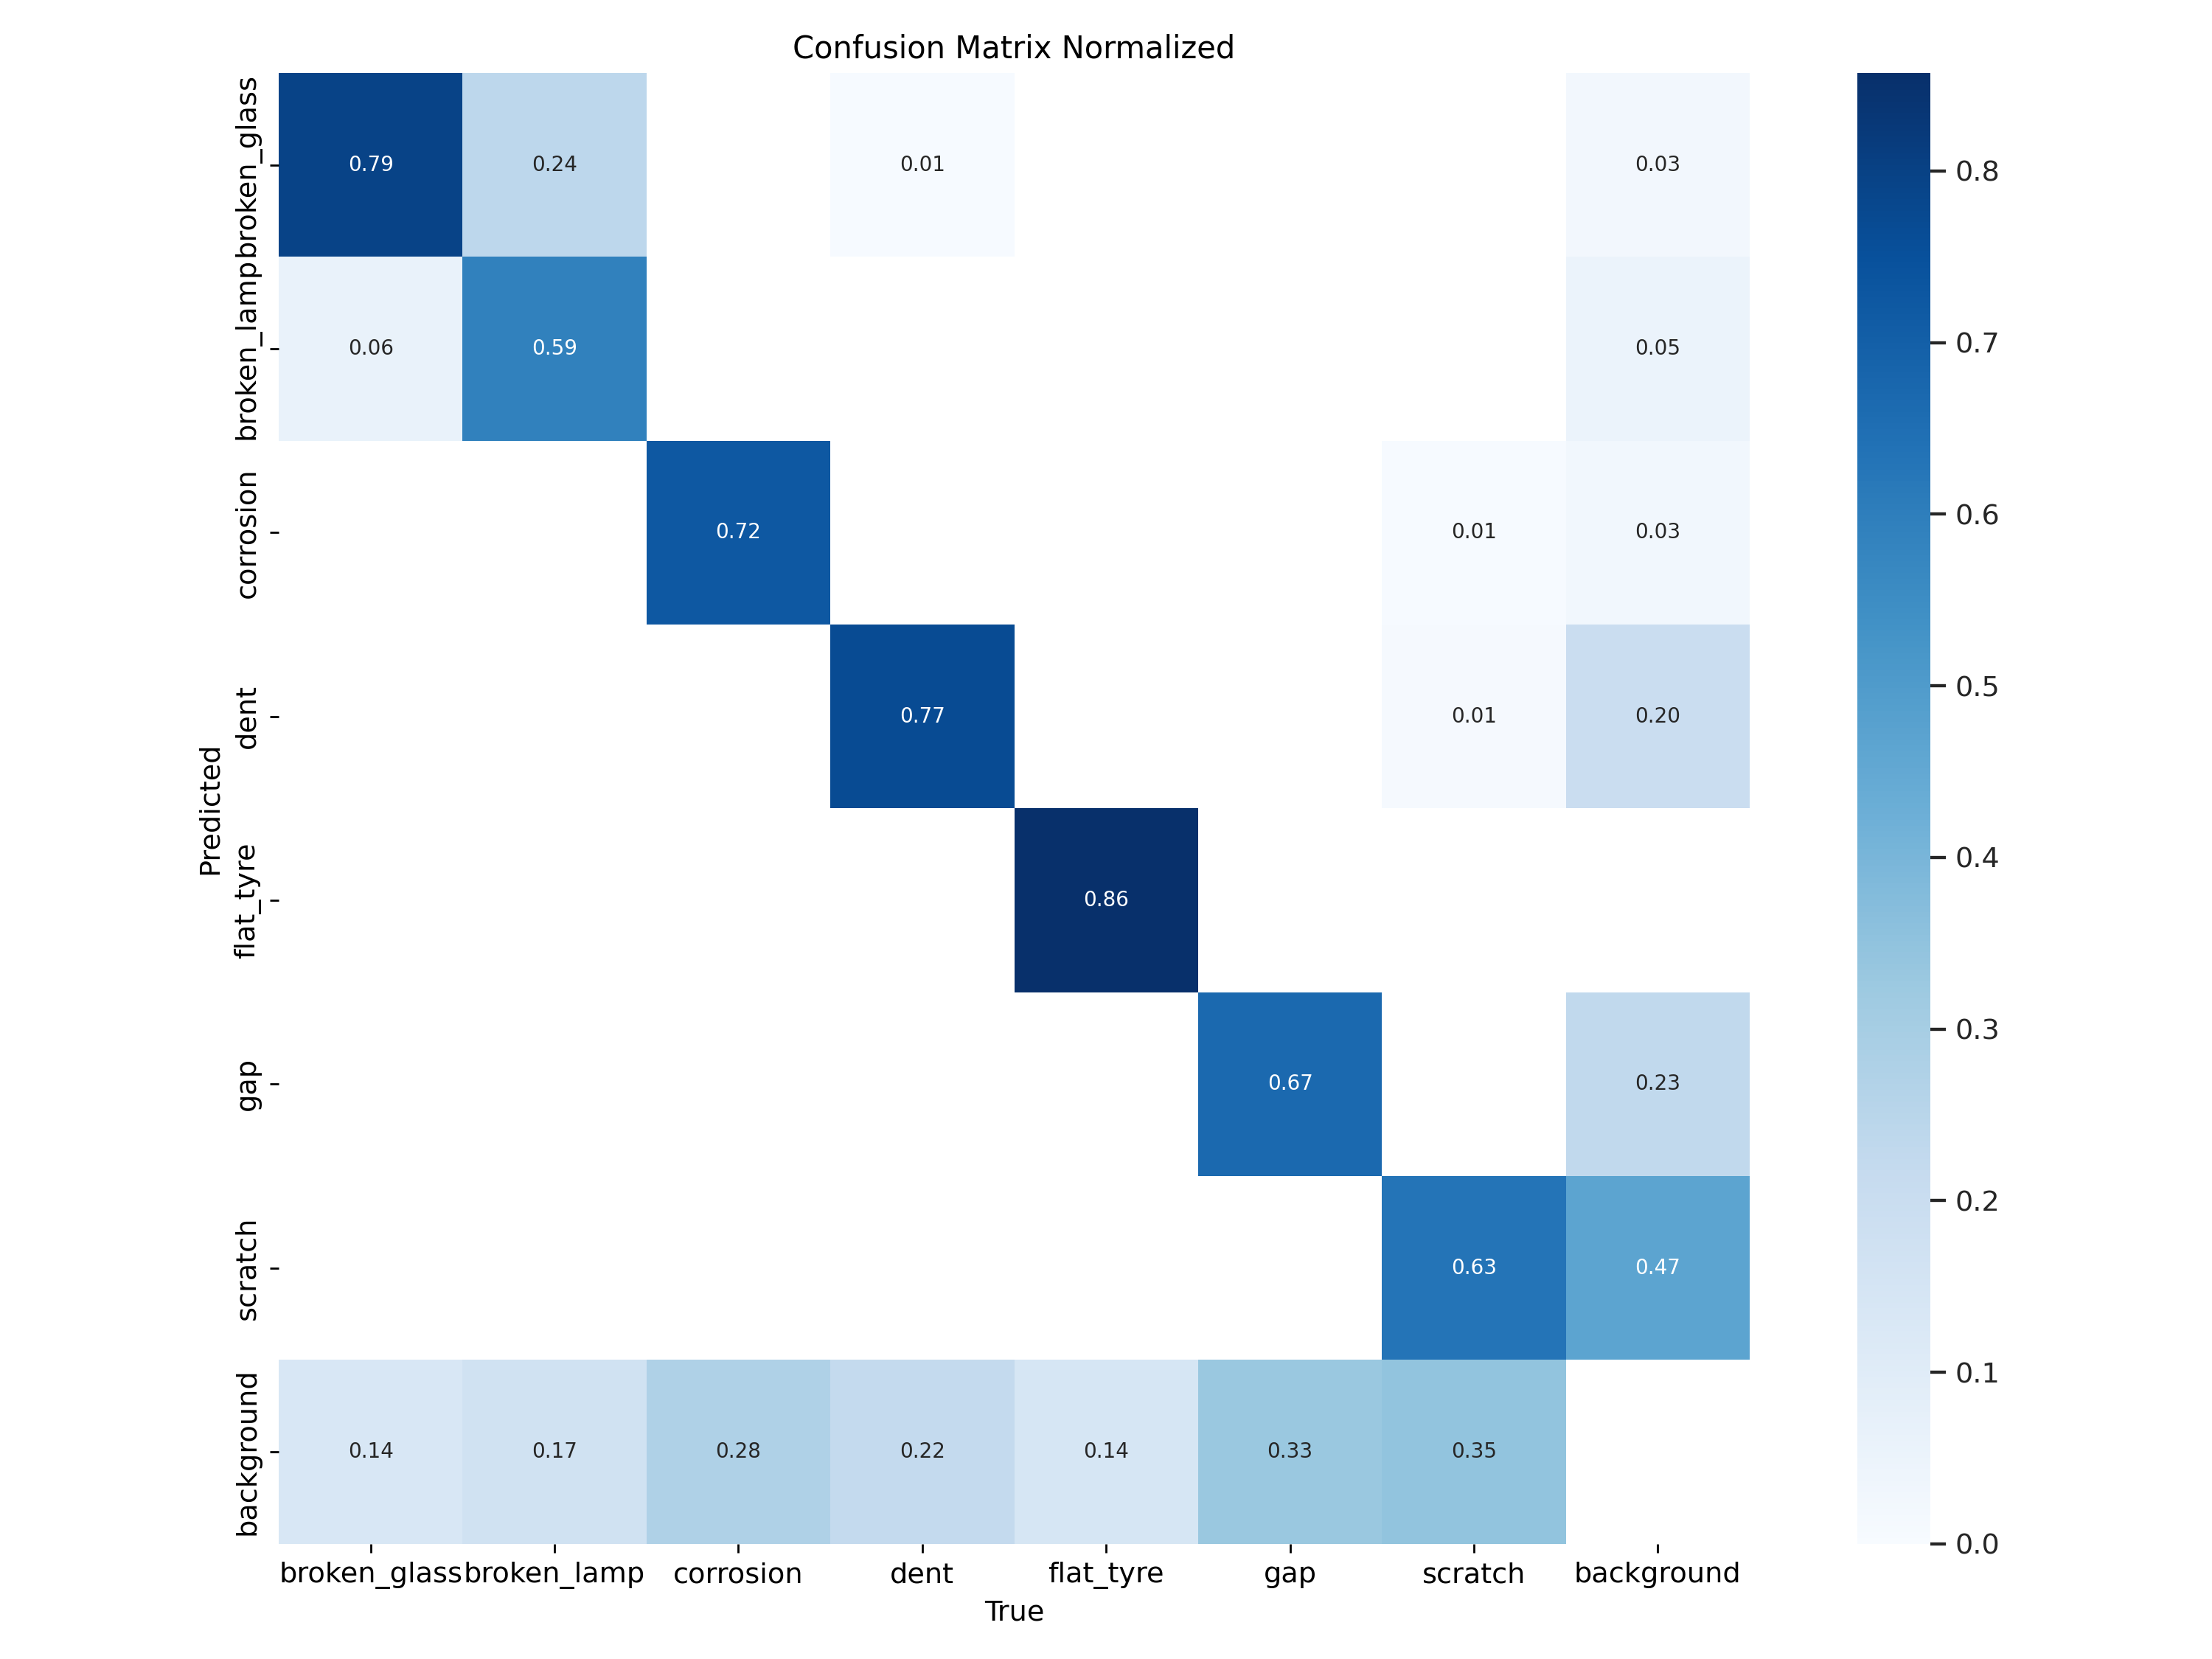

In [23]:
from IPython import display
display.clear_output()

pict_dir = '/content/runs/segment/val2/'
from IPython.display import Image, display

display(Image(filename= pict_dir + 'confusion_matrix_normalized.png'))
print('\n')

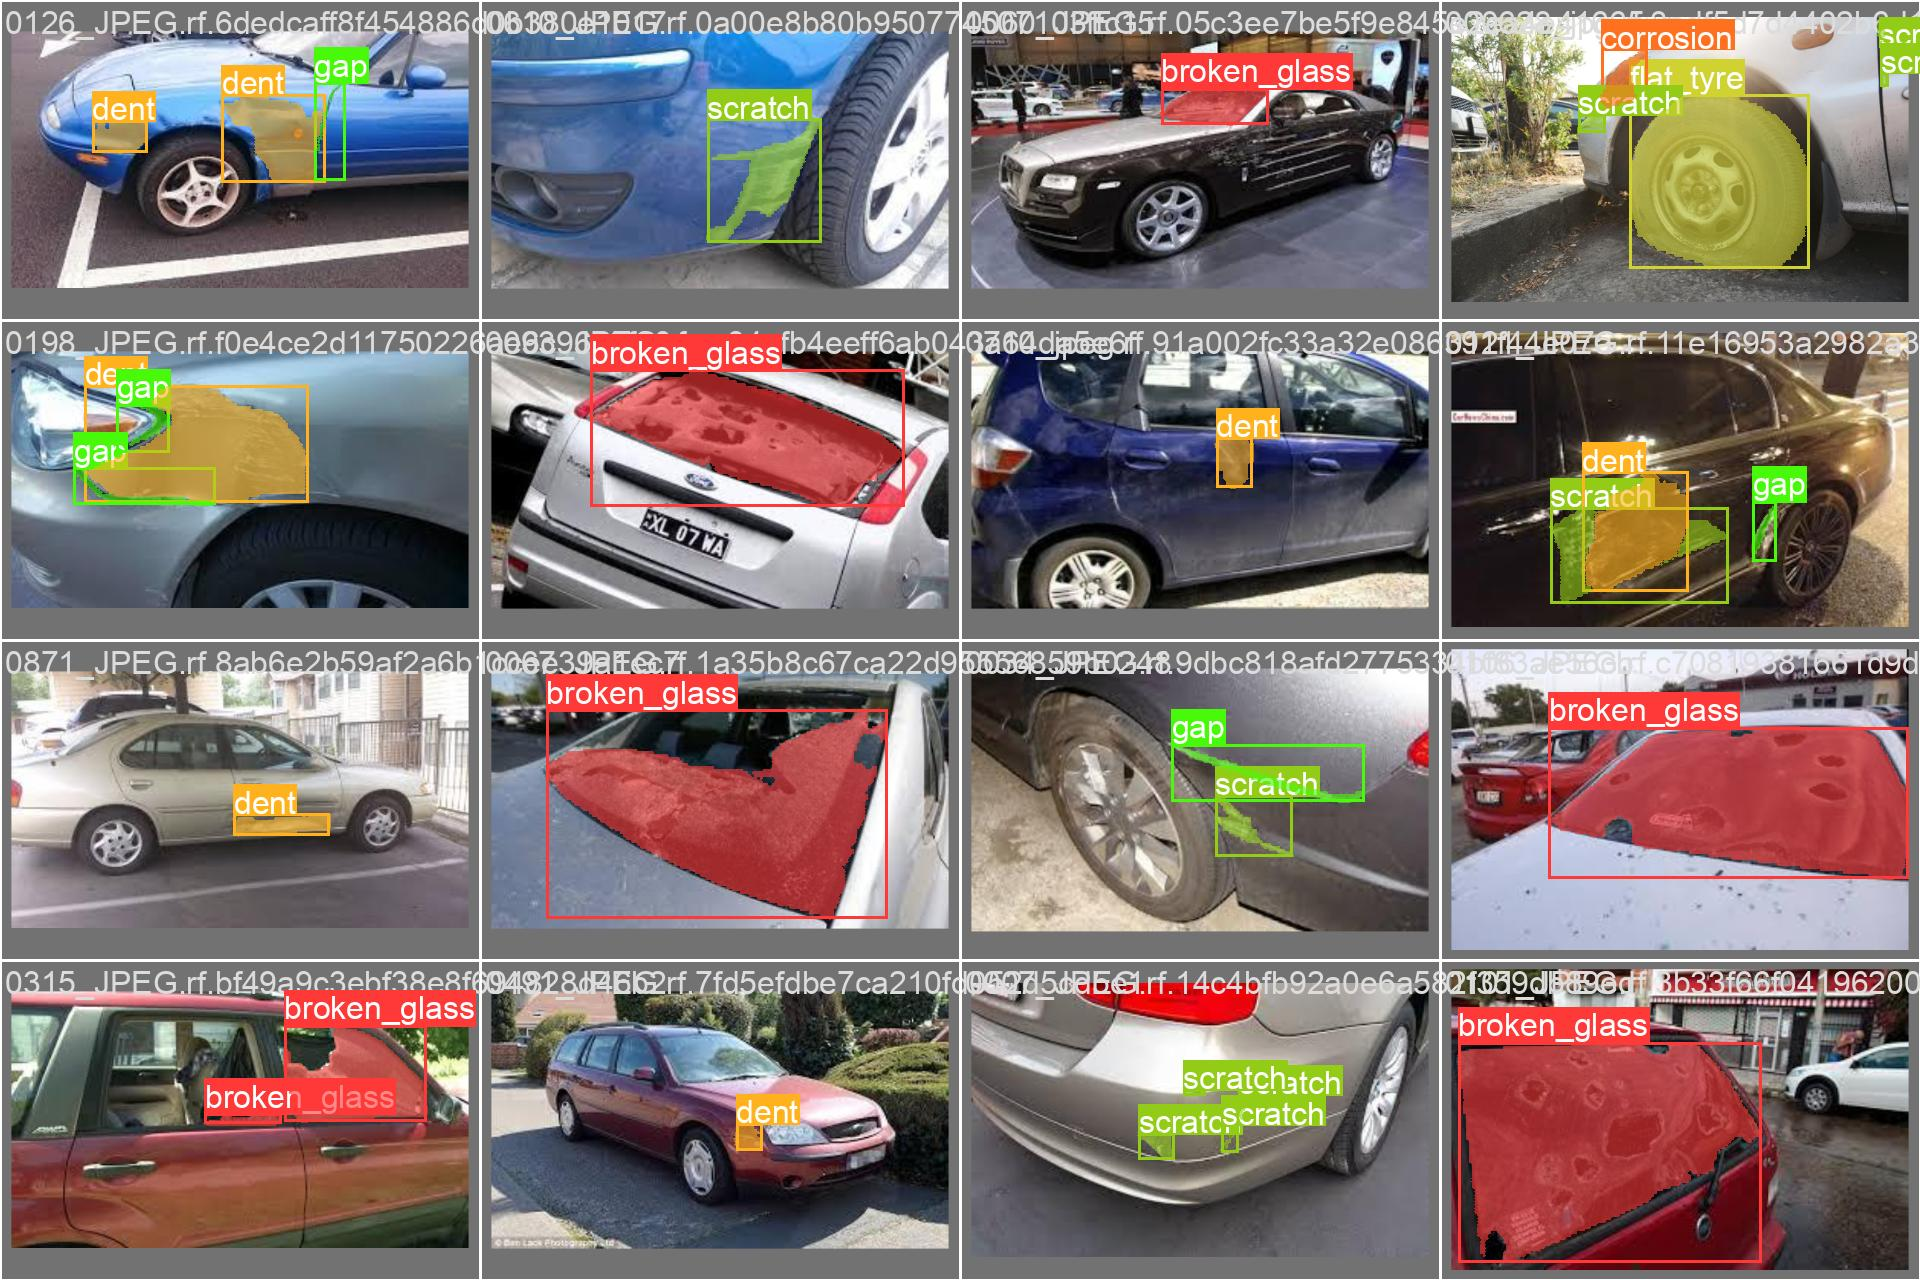

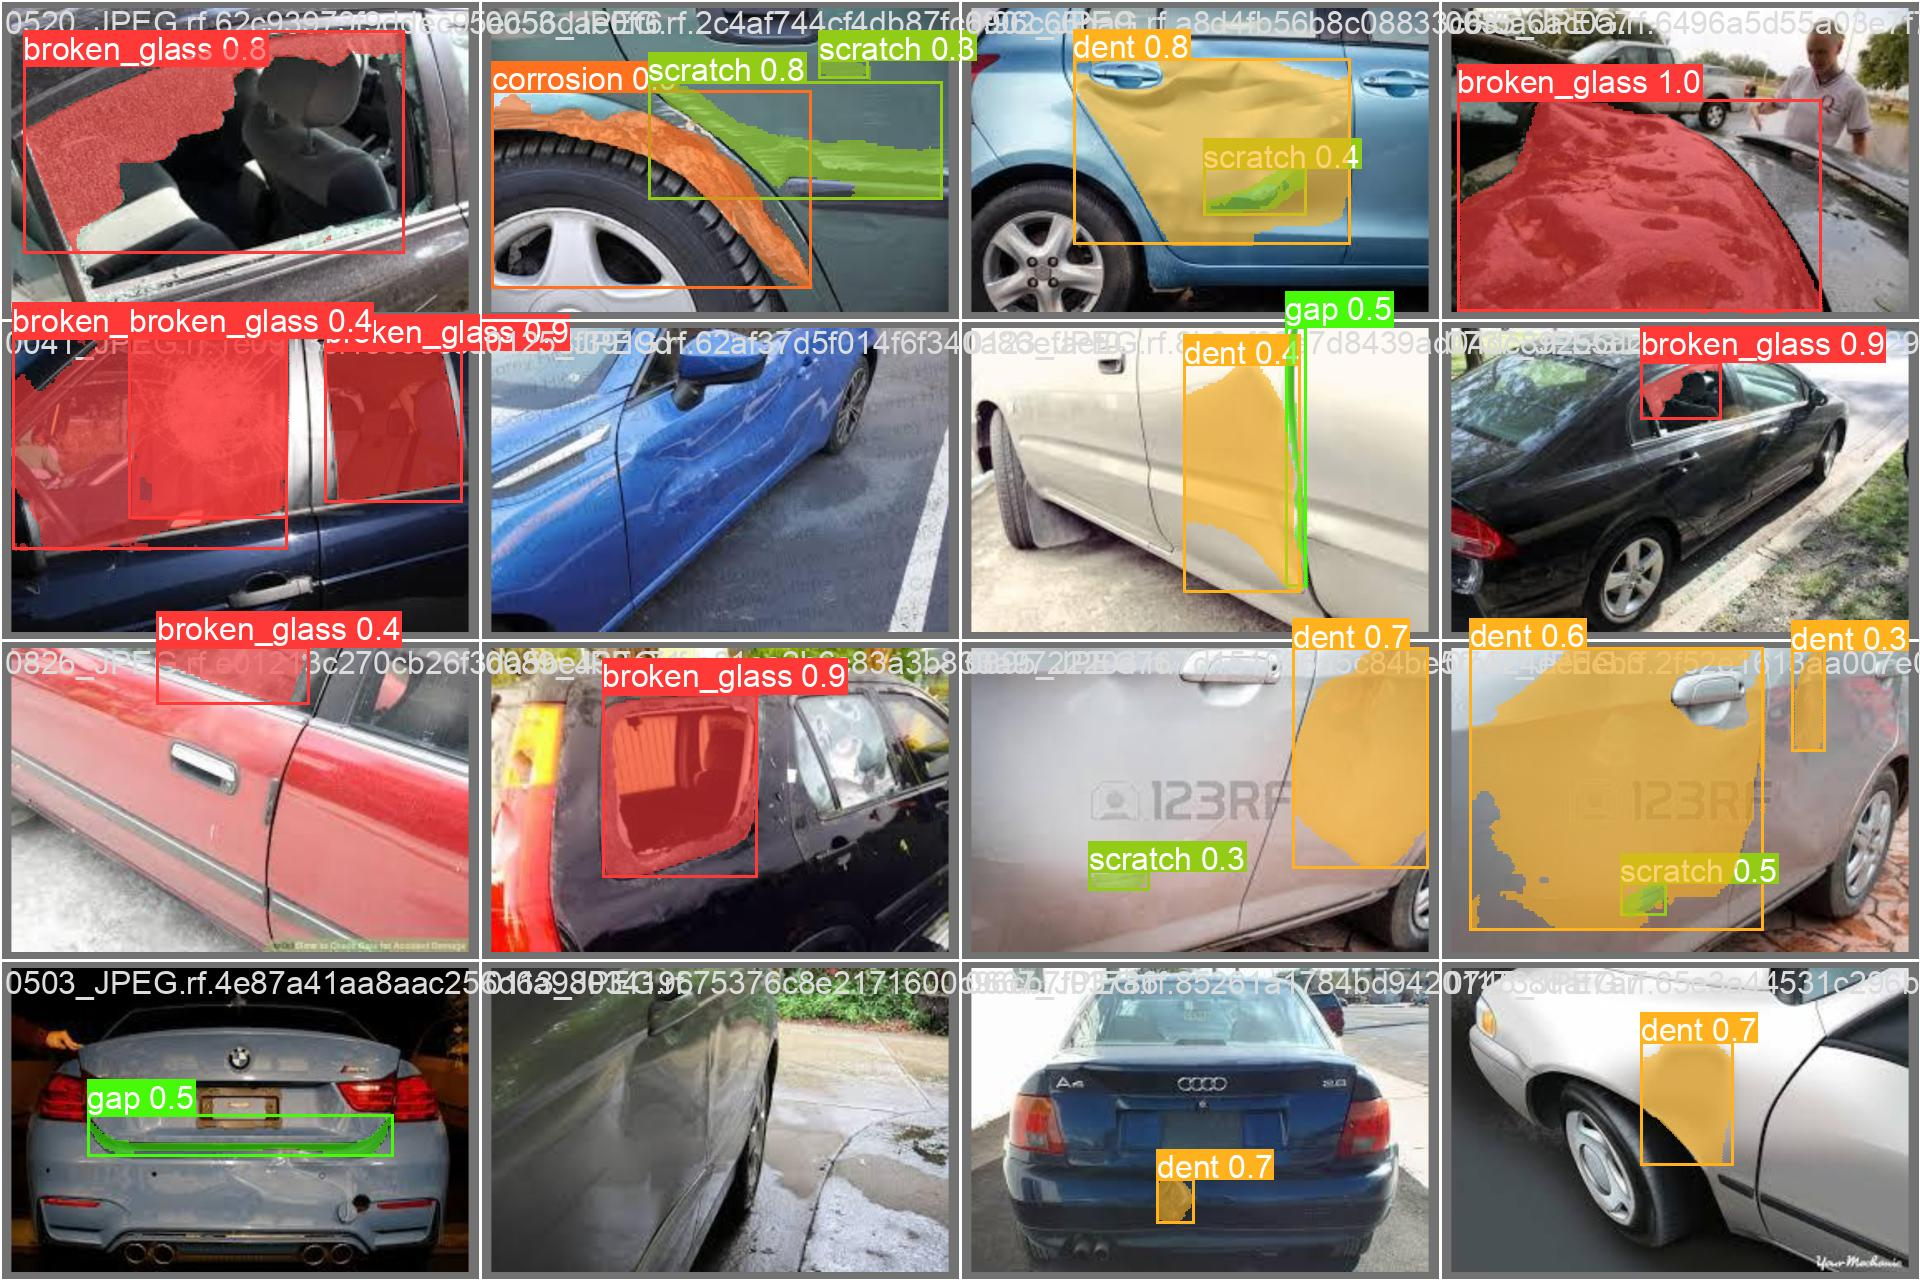

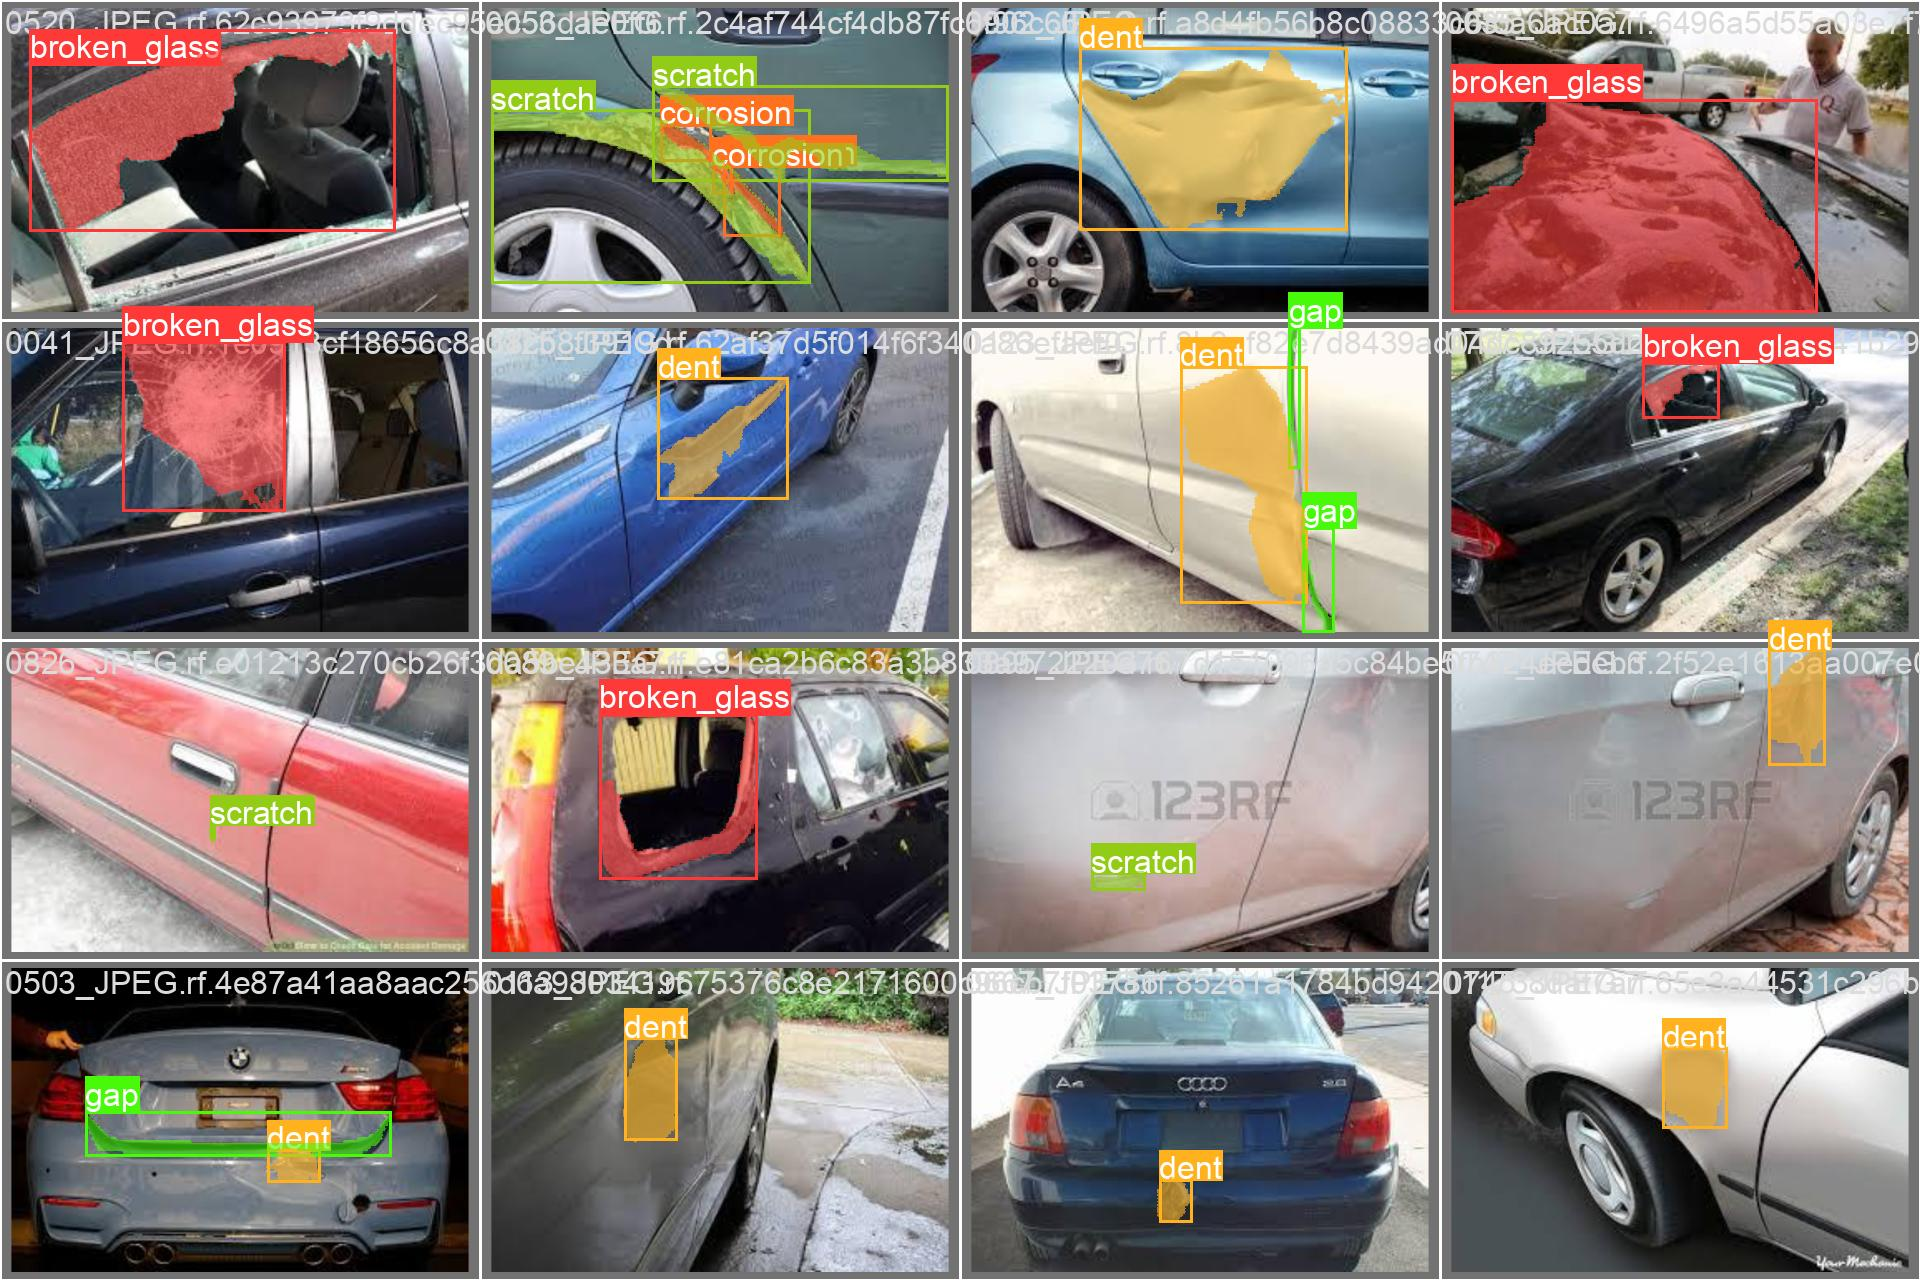

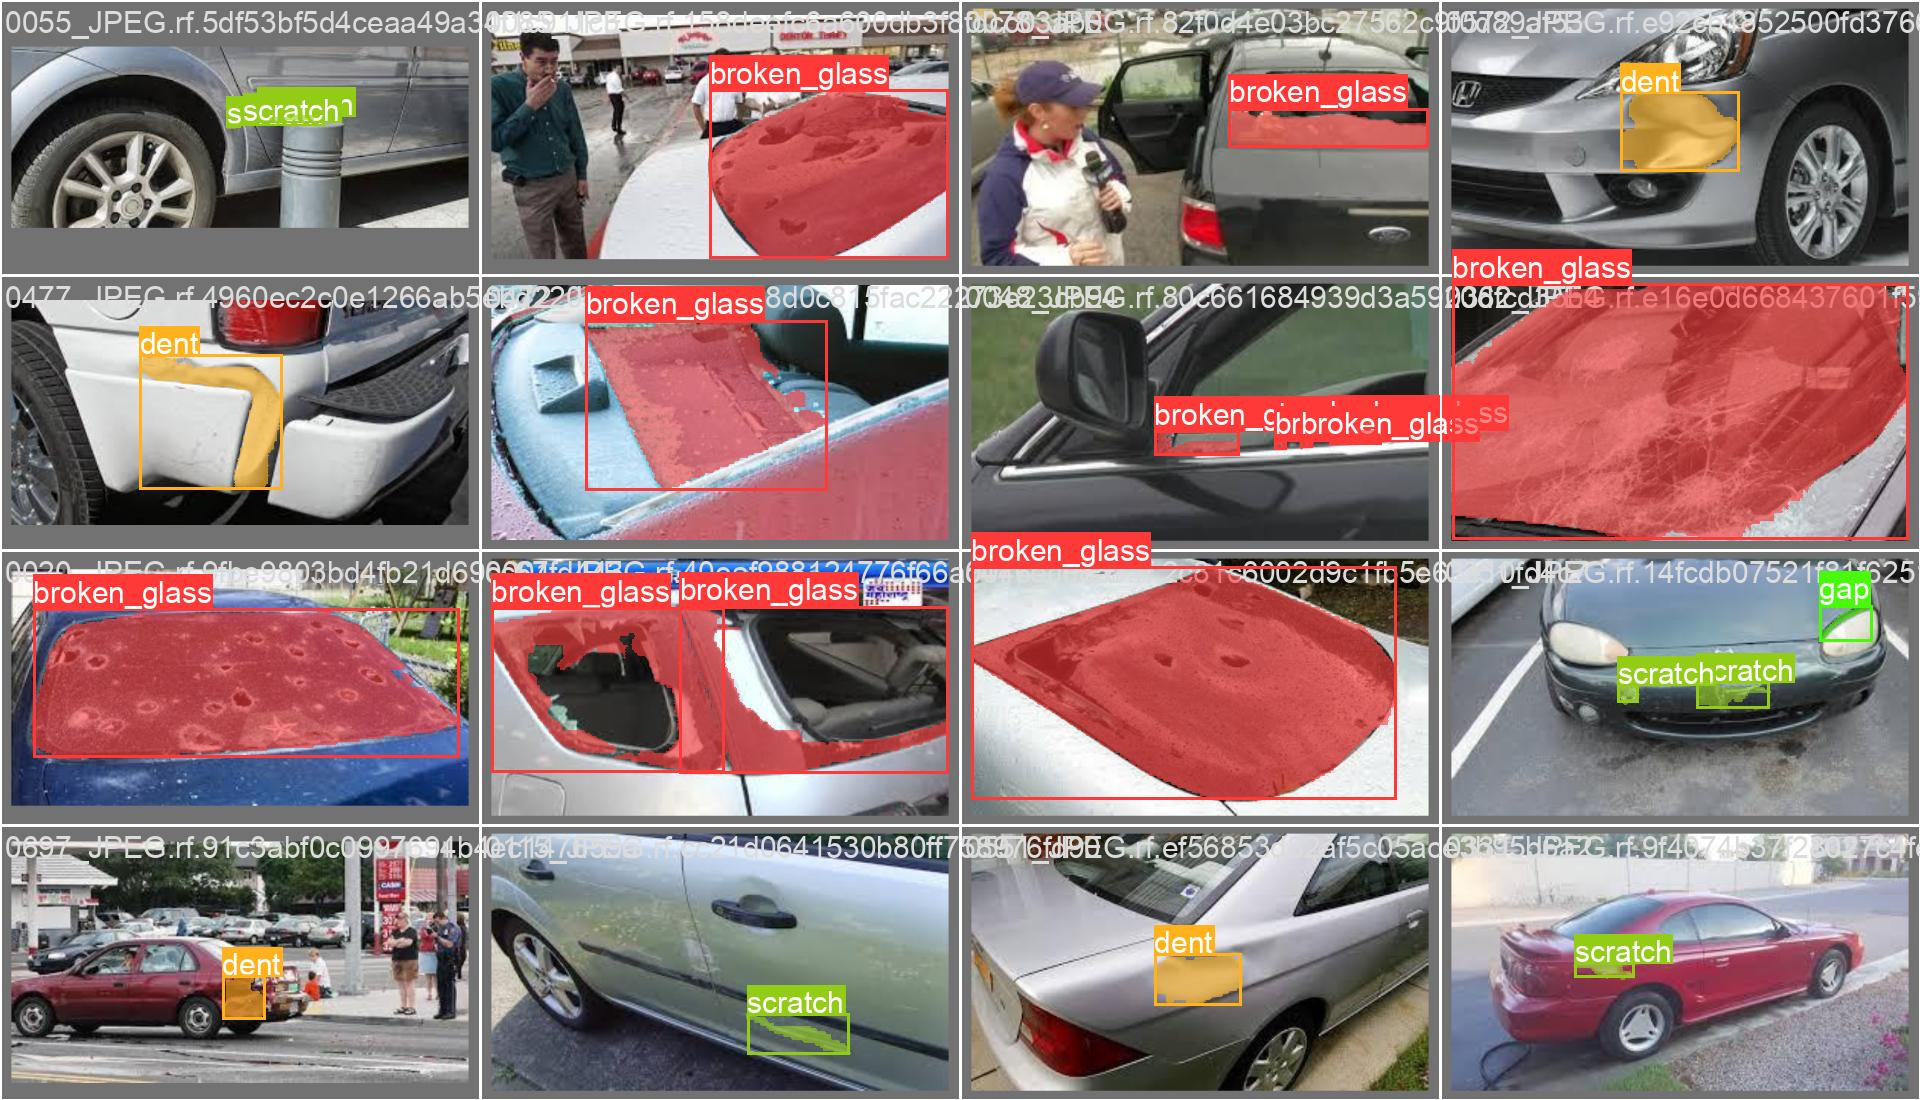

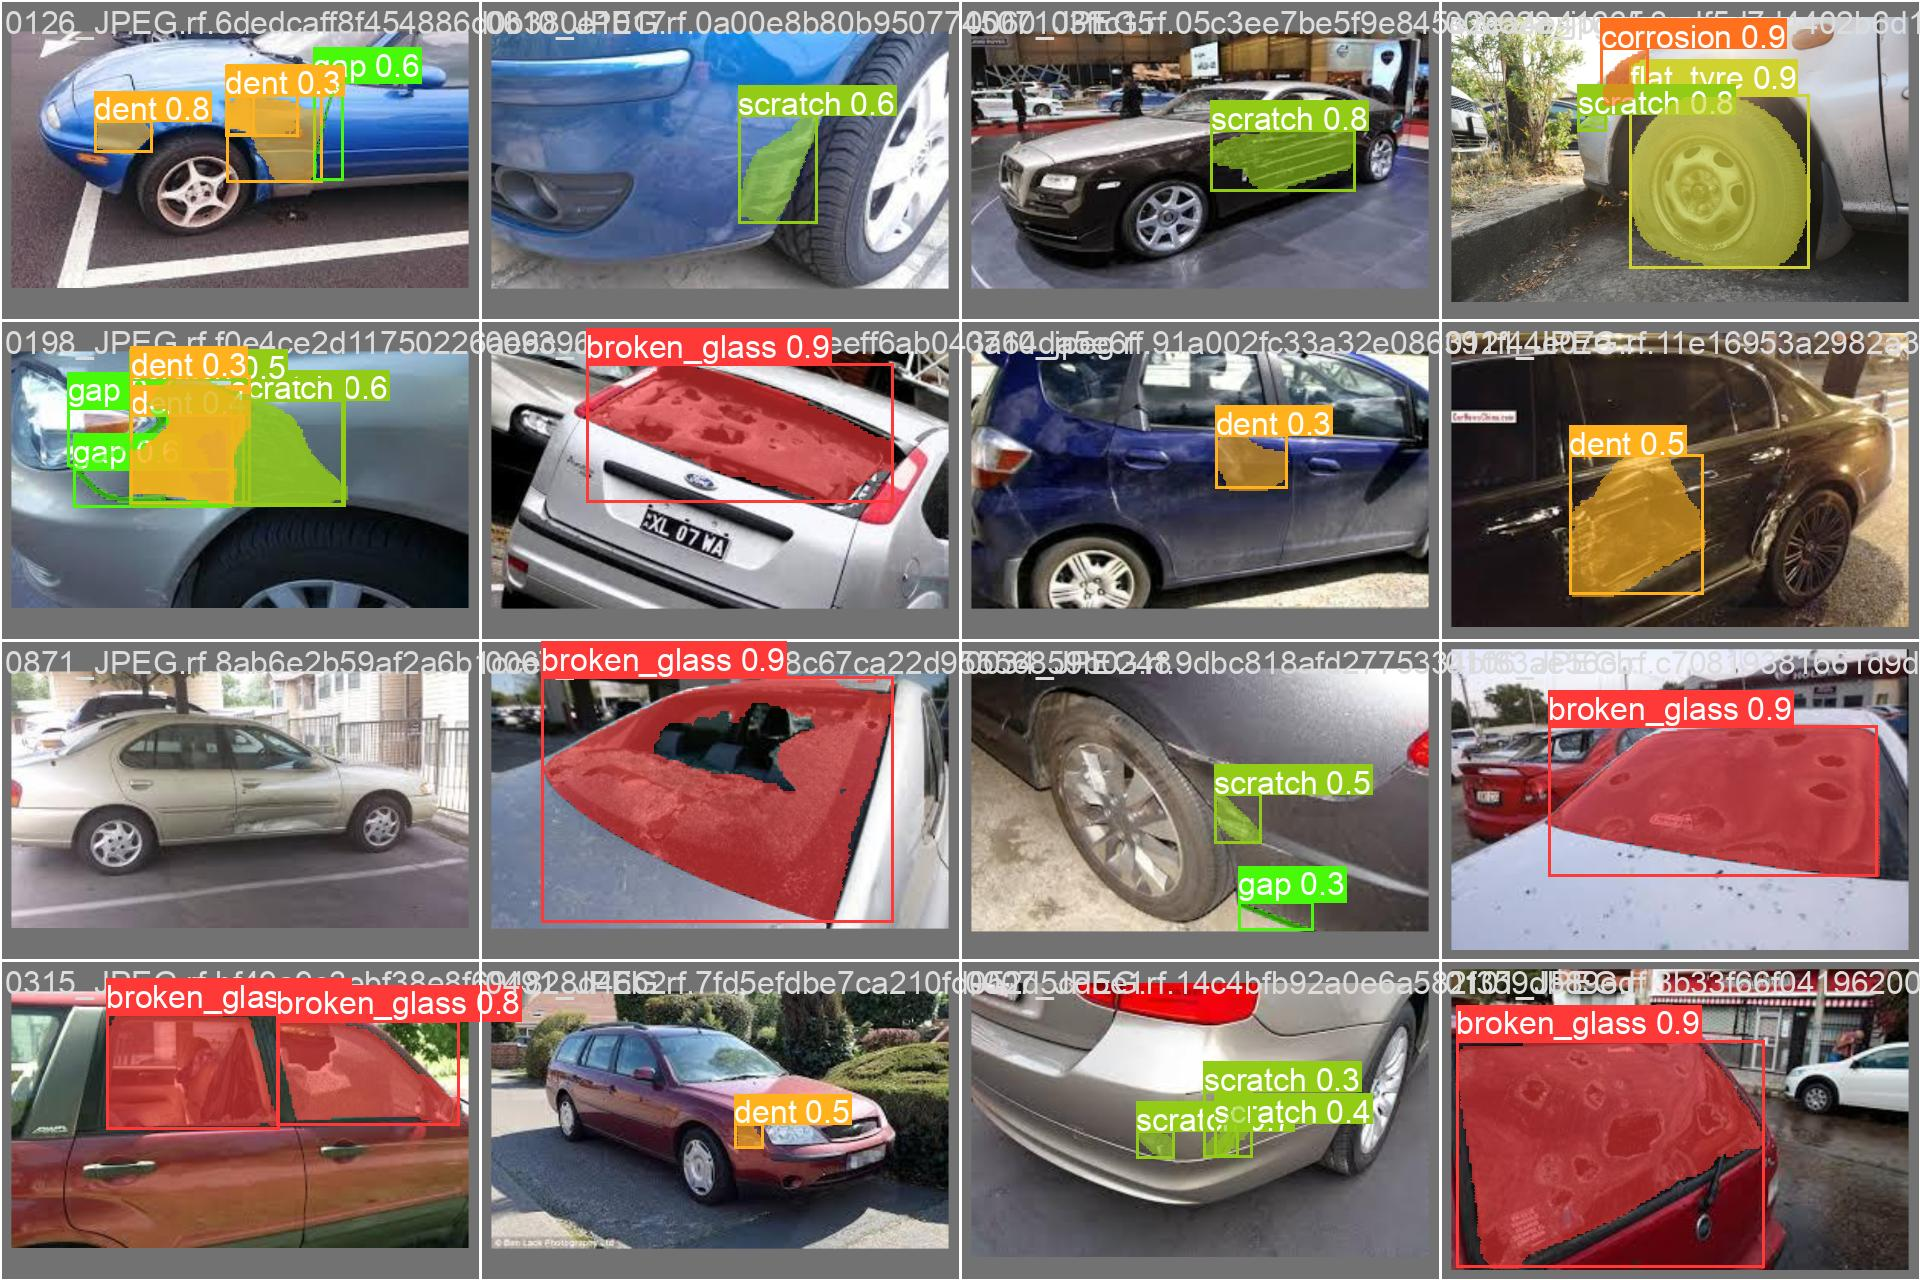

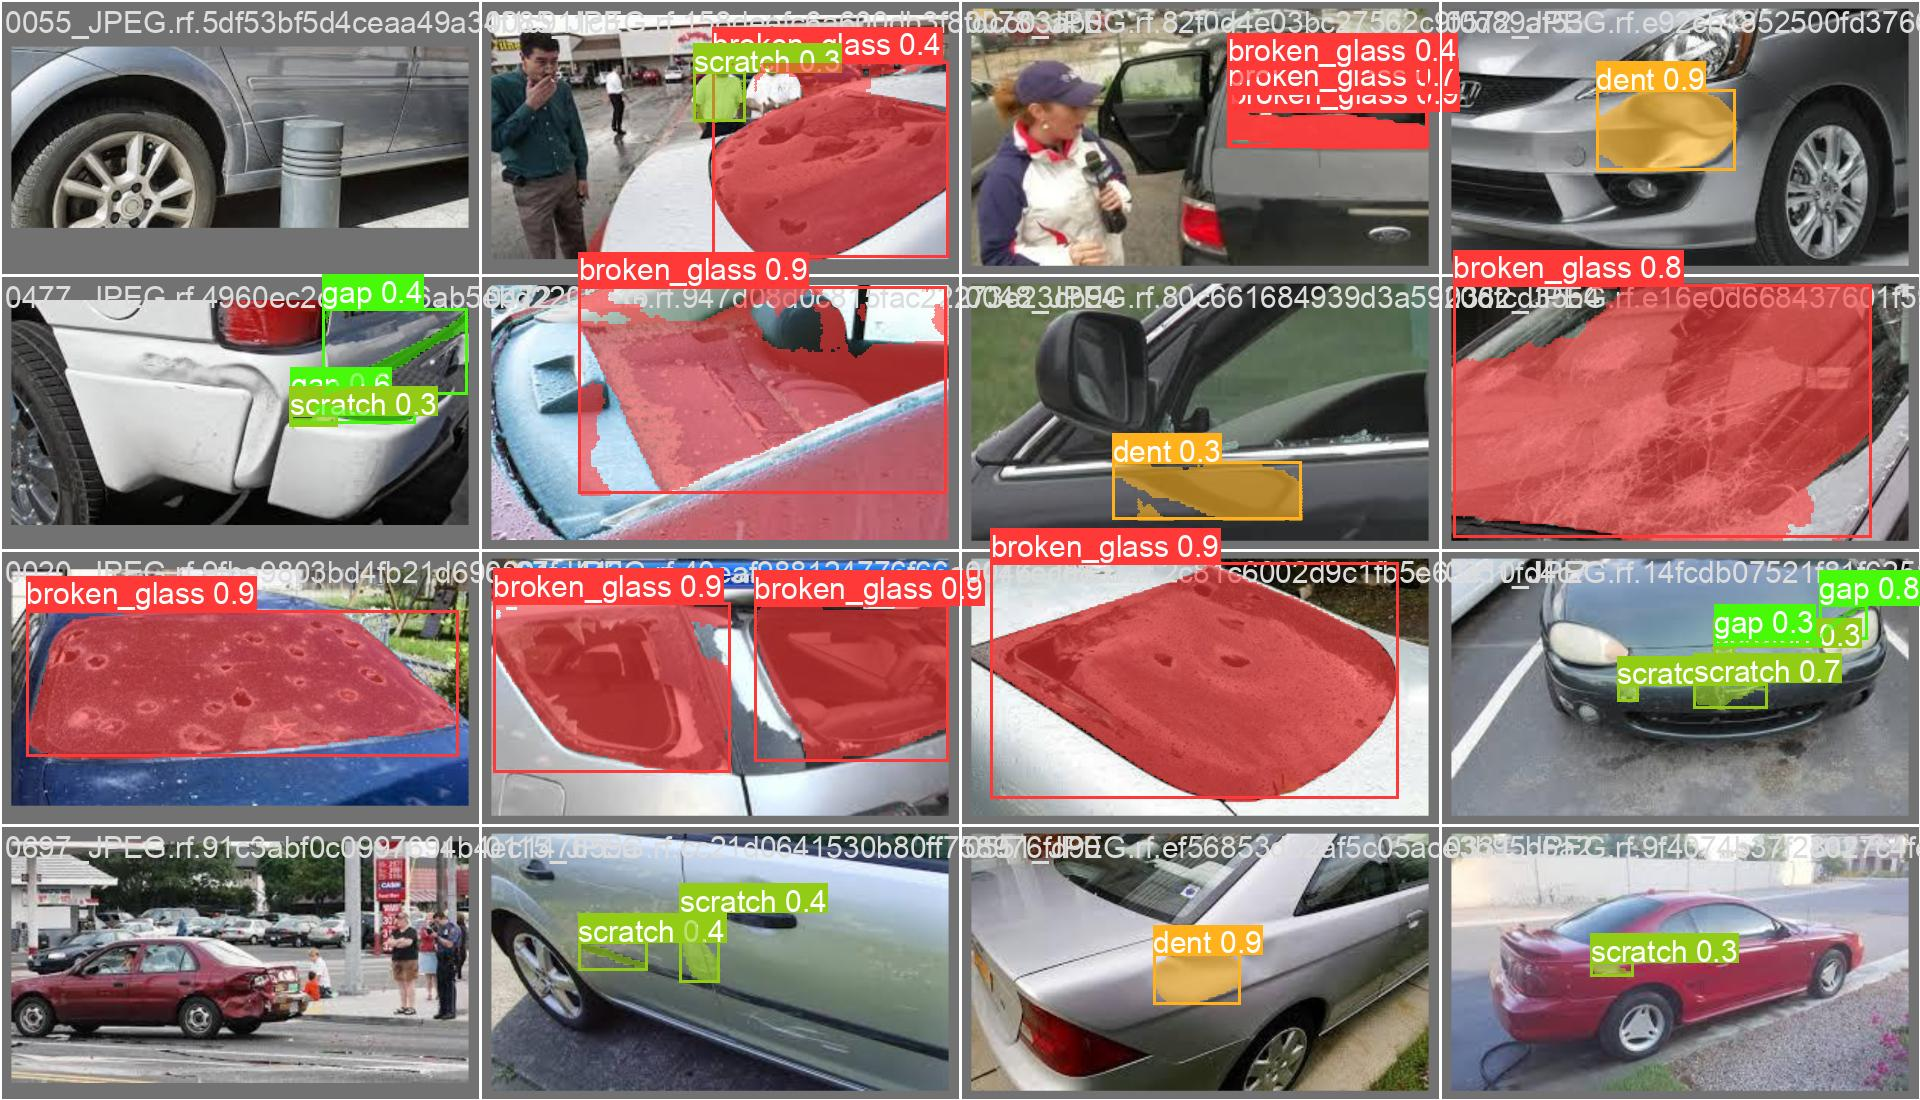

In [24]:
for file in os.listdir(pict_dir):

    if file[-3:] == 'jpg' and file.count('batch') > 0:
        display(Image(filename=pict_dir + file))
        print('\n')

In [ ]:
task.close()